In [ ]:
!pip install corner

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import pandas as pd
import corner
from tqdm import tqdm

In [ ]:
url = "https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt"
DataFrame = pd.read_csv(url,sep=" ",names=["x","y"],engine='python')
X=np.array(DataFrame["x"])
Y=np.array(DataFrame["y"])

In [ ]:
X,Y

(array([ 0.       ,  0.5263158,  1.052632 ,  1.578947 ,  2.105263 ,
         2.631579 ,  3.157895 ,  3.684211 ,  4.210526 ,  4.736842 ,
         5.263158 ,  5.789474 ,  6.315789 ,  6.842105 ,  7.368421 ,
         7.894737 ,  8.421053 ,  8.947368 ,  9.473684 , 10.       ]),
 array([ -3.348886,  10.779   ,  13.12721 ,  21.20879 ,  20.63223 ,
         34.11089 ,  60.66644 ,  55.07888 ,  81.89598 ,  96.83438 ,
        117.5549  , 130.5394  , 147.7079  , 185.1728  , 210.7779  ,
        235.0856  , 266.336   , 297.0943  , 322.7923  , 352.3838  ]))

In [ ]:
m,b,x = sym.symbols("m,b,x", real=True)

Método de regresión logística

In [ ]:
def Model():
  return m*x+b

In [ ]:
def GetGradient():
  Model_x = sym.diff(Model(), m)
  Model_y = sym.diff(Model(), b)

  Model_x_ = sym.lambdify([x,m,b], Model_x)
  Model_y_ = sym.lambdify([x,m,b], Model_y)

  return Model_x_, Model_y_

In [ ]:
def GetSolution(Model,x,y,param,tolerancia,itmax,gamma):
  error = tolerancia + 1
  iters = 0
  Model_x, Model_y = GetGradient()

  while error > tolerancia and iters < itmax:
    sigma = 0

    for i in range(len(y)):
      Modelx = Model_x(x[i],param[0], param[1])
      Modely = Model_y(x[i],param[0], param[1])

      sigma += (y[i]-Model(x[i],param[0],param[1]))*np.array([Modelx,Modely])

    criteria = gamma * (-2*sigma)
    param_new = param - criteria
    param = param_new

    error = np.linalg.norm(criteria)
    iters += 1

  return param_new

In [ ]:
Model_ = sym.lambdify([x,m,b],Model())
param = np.array([1,1])
gamma = 1e-3
tolerancia = 0.0001
itmax = 10000

In [ ]:
param_solution = GetSolution(Model_,X,Y,param,tolerancia,itmax,gamma)

In [ ]:
Reduced_Model = Model().subs([(m, param_solution[0]),
                              (b, param_solution[1])])

Reduced_Model

35.6552651777436*x - 45.4523999625727

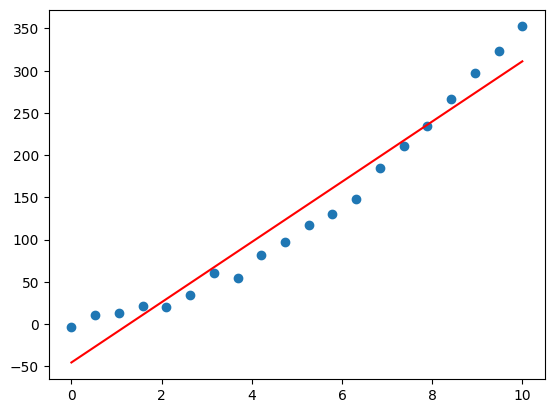

In [ ]:
plt.scatter(X,Y)
y1 = lambda x: param_solution[1] + param_solution[0]*x
plt.plot(X,y1(X),color="red")

Método de regresión matricial (combinacion linel de funciones, ej: polinomio)

In [ ]:
P = np.array([np.ones(X.shape[0]), X]).T
param = (np.linalg.inv(P.T @ P) @ P.T) @ Y
param

array([-45.46163845,  35.6566259 ])

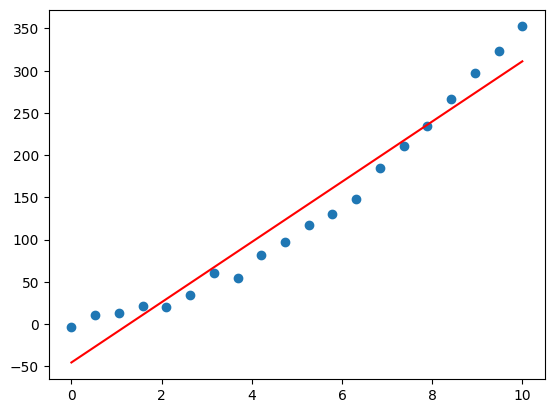

In [ ]:
y2 = lambda x: param[0] + param[1]*x
plt.scatter(X,Y)
plt.plot(X,y2(X),color="red")

Código alternativo al método de regresión matricial

In [ ]:
def GetFit(x,y,n):

    l = x.shape[0]
    b = y

    A = np.ones((l,n+1))

    for i in range(1,n+1):
        A[:,i] = x**i

    AT = np.dot(A.T,A)
    bT = np.dot(A.T,b)

    try:
      xsol = np.linalg.solve(AT,bT)
    except np.linalg.LinAlgError:
      xsol = None


    return xsol

Método exclusivo de regresión lineal
https://github.com/diegour1/CompMetodosComputacionales/blob/main/Notebooks/05%20-%20fit_lineal_y_solucion_sistema_de_ecuaciones.ipynb

In [ ]:
sumx = np.sum(X)
sumy = np.sum(Y)
m_ = (np.sum(X*Y) - sumx*sumy / len(X))/(np.sum(X**2) - sumx**2/len(X))
b_ = (sumy - m_*sumx)/len(X)

In [ ]:
m_,b_

(35.65662590093288, -45.461638448098164)

Método adicional: Minimos Bootstrapping

In [ ]:
def Resample(sample):

    resample_ = np.random.choice( sample, size=len(sample), replace=True )
    return resample_


In [ ]:
dict1 = dict(zip(X,Y))

In [ ]:
def GetBootstrapping(x,n,NTrials=int(3e4)):

    Values = np.zeros((NTrials,n+1))

    for i in tqdm(range(NTrials)):

        x1 = Resample(x)

        y1 = np.array([])
        for j in x1:
            y1 = np.append(y1,dict1[j])

        p = GetFit(x1,y1,n)

        if p is not None:
          Values[i] = p

    return Values

In [ ]:
Mean_Dist = GetBootstrapping(X,1)

100%|██████████| 30000/30000 [00:07<00:00, 4170.72it/s]


(array([2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 6.000e+00, 8.000e+00,
        1.500e+01, 2.900e+01, 2.700e+01, 4.900e+01, 8.700e+01, 1.310e+02,
        1.950e+02, 2.640e+02, 4.320e+02, 6.830e+02, 9.360e+02, 1.268e+03,
        1.857e+03, 2.361e+03, 3.189e+03, 3.691e+03, 3.931e+03, 3.884e+03,
        3.218e+03, 2.071e+03, 1.116e+03, 4.310e+02, 1.000e+02, 1.500e+01]),
 array([-137.34328093, -133.12731907, -128.91135722, -124.69539536,
        -120.4794335 , -116.26347165, -112.04750979, -107.83154793,
        -103.61558608,  -99.39962422,  -95.18366236,  -90.96770051,
         -86.75173865,  -82.53577679,  -78.31981494,  -74.10385308,
         -69.88789122,  -65.67192937,  -61.45596751,  -57.24000565,
         -53.0240438 ,  -48.80808194,  -44.59212008,  -40.37615823,
         -36.16019637,  -31.94423451,  -27.72827266,  -23.5123108 ,
         -19.29634894,  -15.08038709,  -10.86442523]),
 <BarContainer object of 30 artists>)

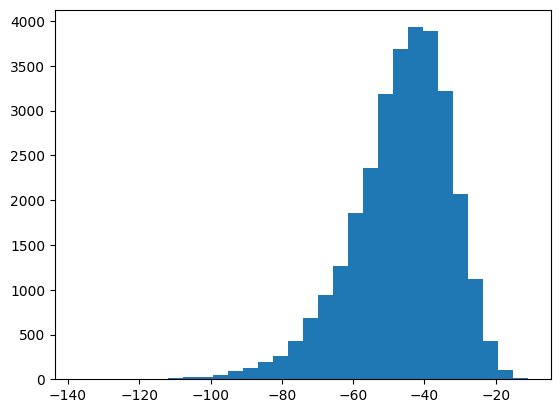

In [ ]:
plt.hist(Mean_Dist[:,0],bins=30)

In [ ]:
params = np.percentile(Mean_Dist,50,axis=0)
params

array([-44.82646904,  35.64502298])

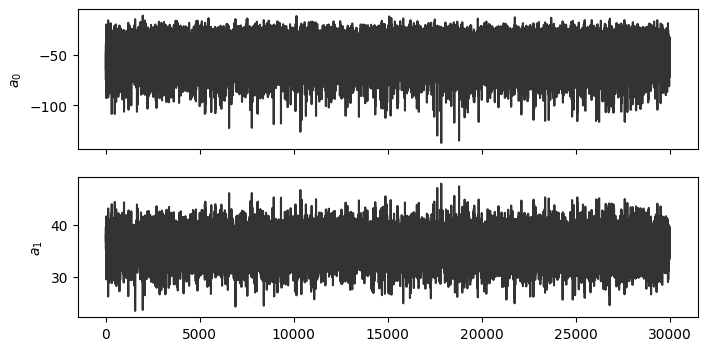

In [ ]:
fig, axes = plt.subplots( len(params), figsize=(8,4), sharex=True )
labels=[r'$a_{0}$',r'$a_{1}$',r'$a_{2}$',r'$a_{3}$']
for i in range(len(params)):

    ax = axes[i]
    ax.plot(Mean_Dist[:,i],'k',alpha=0.8)
    ax.set_ylabel(labels[i])

axes[-1].set_label('Step numer')

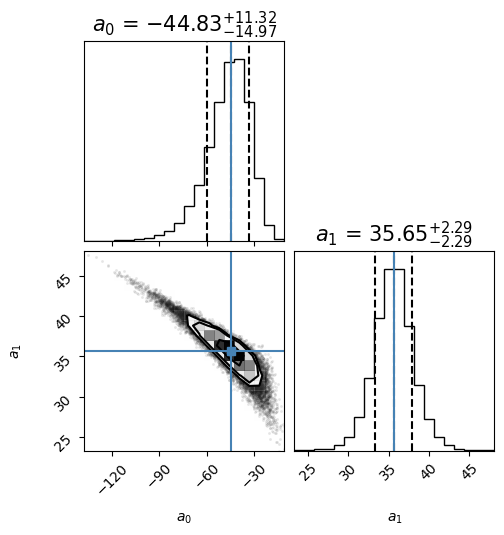

In [ ]:
truths = params
figure = corner.corner( Mean_Dist,
                       truths = truths,
                       labels = labels,
                       quantiles = [0.16,0.50,0.84],
                       show_titles=True,
                      title_kwargs={'fontsize':15})